## Plotting Curves of interesting regions

In [1]:
import xarray as xr
import numpy as np
import os
import glob
import pandas
from datetime import datetime
import matplotlib as mpl
import matplotlib.patches as mpatches
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.ticker as mticker
import matplotlib.patheffects as pe
from matplotlib.colors import BoundaryNorm
from matplotlib.colors import TwoSlopeNorm
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.ticker import (LongitudeFormatter, LatitudeFormatter,
                                LatitudeLocator, LongitudeLocator)
import scipy.stats as stats
import matplotlib.dates as mdates
from tqdm.notebook import tqdm
import seaborn as sns

In [2]:
save = False # set to TRUE to save figures

## Figure 3

To show temporal variability, the monthly averages for every year and every grid cell contained in the bounding boxes for the timespan between 01.01.1941 and 01.04.2025 are spatially averaged and plotted as boxplots for each month.

#### The Bounding boxes

* Central Siberia
* Central Europe
* US Midwest
* Taklamakan Desert
* India
* The Sahel
* Amazon Basin
* Australia
* Antarctica

In [3]:
# bounding_box = {'Name': [lat_min, lat_max, lon_min, lon_max, 'color']}

bounding_boxes = {
    'Central Siberia (55 - 70° N; 90 - 140 °E)': [55, 70, 90, 140, '#1f77b4'],
    'Central Europe (46 - 54 ° N; 8 - 20 °E)': [46, 54, 8, 20, '#2ca02c'],
    'US Midwest (40 - 48 °N; 85 - 100 °W)': [40, 48, -100, -85, '#17becf'],
    'Taklamakan Desert (37 - 42° N; 76 - 90° E)': [37, 42, 76, 90, '#ff7f0e'],
    'India (8 - 36° N; 68 - 98° E)': [8, 36, 68, 98, '#7f7f7f'],
    'The Sahel (12 - 18 °N; 10 °W - 25 °E)': [12, 18, -10, 25, '#8c564b'],
    'Amazon Basin (0 - 15° S; 50 - 70 °W)': [-15, 0, -70, -50, '#d62728'],
    'Australia (20 - 30 °S; 120 - 140 °E)': [-30, -20, 120, 140, '#e377c2'],
    'Antarctica (75 - 90 °S)': [-90, -75, -180, 180, '#9467bd']
}

In [4]:
ds = xr.open_dataset('residence_time.nc').traveltime_mean
ds = ds.where(ds != 0)
ds = ds/24

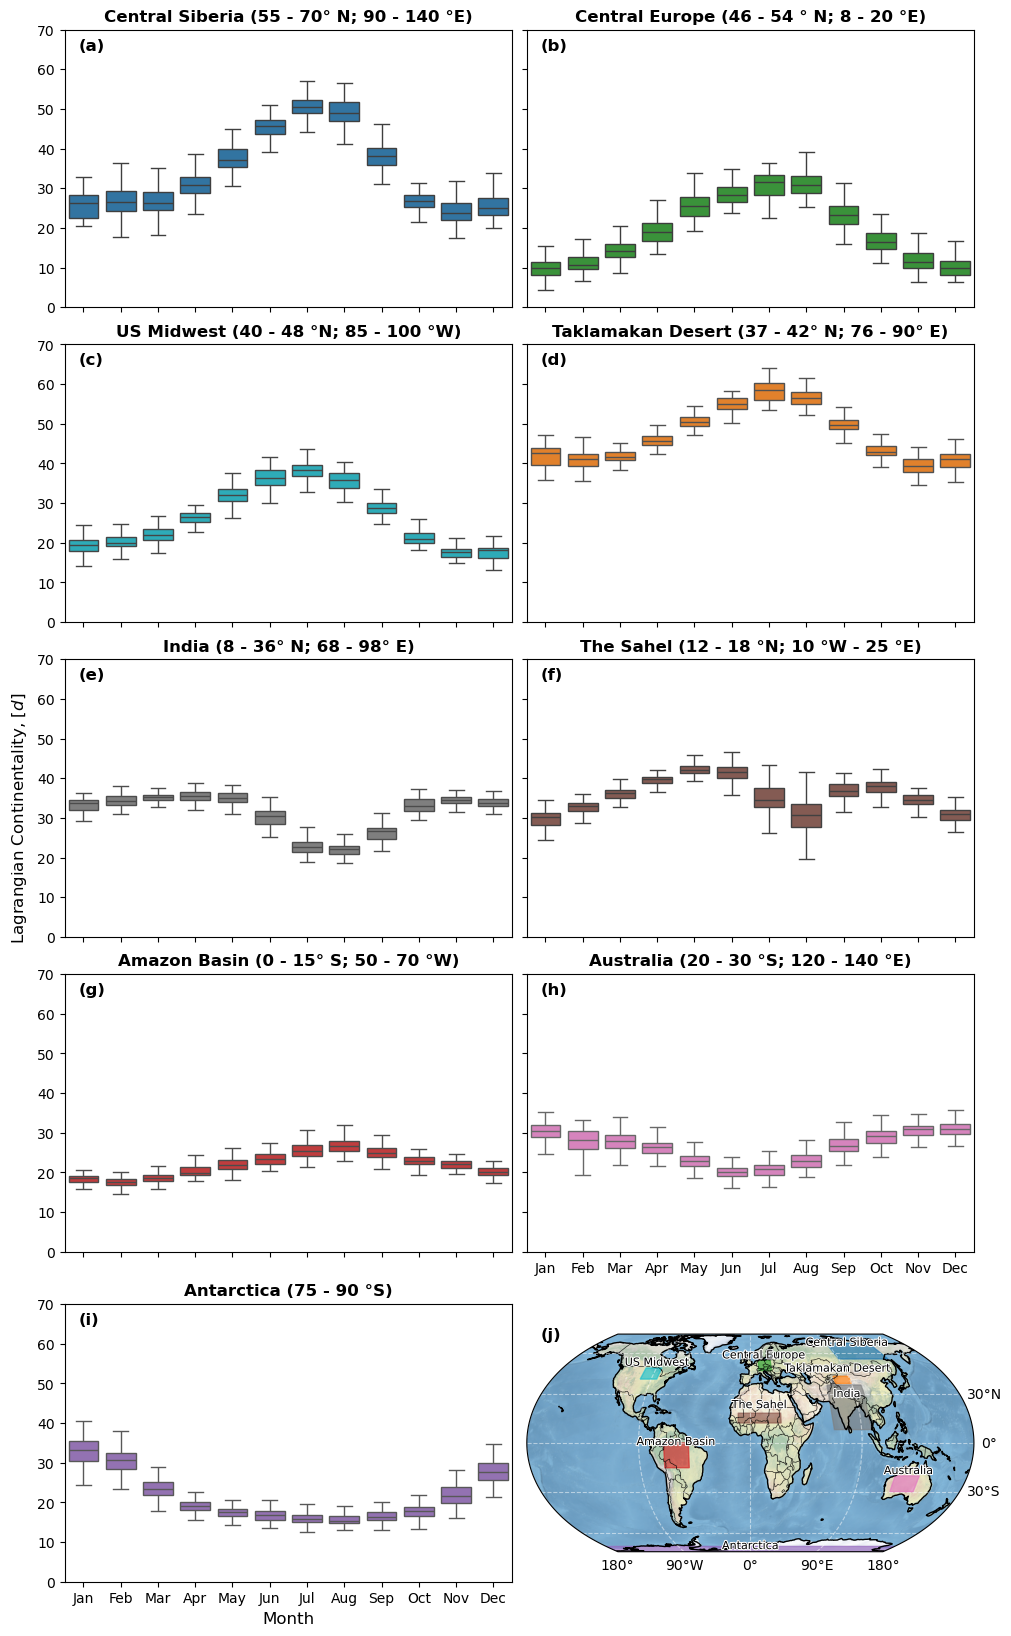

In [5]:
fig, axs = plt.subplots(5, 2, 
                        figsize=(10, 17), 
                        layout='compressed', 
                        sharex=True, 
                        sharey=True)

axs_flat = axs.flatten()
region_names = list(bounding_boxes.keys())

for i in range(len(axs_flat)-1):
    ax = axs_flat[i]
    title = region_names[i]
    params = bounding_boxes[title]
    lat_min, lat_max, lon_min, lon_max, color = params
    
    box = ds.sel(lat=slice(lat_min, lat_max), lon=slice(lon_min, lon_max)) #, time=slice('1980', '2023'))
    weights = np.cos(np.deg2rad(box.lat))
    ts_mean = box.weighted(weights).mean(dim=['lat', 'lon'], skipna=True)
    
    ts_mean_df = ts_mean.to_dataframe(name='residence_time')
    ts_mean_df['month'] = ts_mean_df.index.month
    
    sns.boxplot(
        x='month', 
        y='residence_time', 
        data=ts_mean_df, 
        ax=ax,
        color=color,
        showfliers=False,
    )
    
    ax.set_xticks(np.arange(0, 12, 1))
    ax.set_xticklabels(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 
                        'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
    ax.set_title(title, fontsize=12, fontweight='bold')
    ax.set_xlabel("") # for some reason this is the only way to remove the labels that sns.boxplot puts in
    ax.set_ylabel("")

    if i % 2 != 0:
        ax.set_ylabel('')
        ax.tick_params(labelleft=False) 
    if i < 6: 
        ax.set_xlabel('')
        ax.tick_params(labelbottom=False)
    
    # label the subplots a through i
    subplot_label = f"({chr(ord('a') + i)})" 
    ax.text(0.03, 0.97, subplot_label, 
            transform=ax.transAxes, 
            fontsize=12, 
            fontweight='bold', 
            va='top', 
            ha='left')
    
axs[0, 0].set_ylim(0, 70)

axs[3, 1].tick_params(labelbottom=True)
axs[3, 1].set_xlabel('Month', fontsize=12)
axs[4, 0].set_xlabel('Month', fontsize=12)
axs[4, 1].remove()

map_ax = fig.add_subplot(5, 2, 10, projection=ccrs.EqualEarth())

map_ax.coastlines()
map_ax.add_feature(cfeature.BORDERS, edgecolor='k', linewidth=0.5, alpha=0.8)
map_ax.stock_img()

gl = map_ax.gridlines(
    linestyle='--',
    color='white',
    alpha=0.5,
    draw_labels={'bottom': True, 'right': True, 'left': False, 'top': False}
)
gl.ylocator = mticker.FixedLocator([-60, -30, 0, 30, 60])
gl.xlocator = mticker.FixedLocator(range(-180, 181, 90))

for boxname in bounding_boxes.keys():
    lat_min, lat_max, lon_min, lon_max, color = bounding_boxes[boxname]
    box_patch = mpatches.Rectangle(
        xy=[lon_min, lat_min],
        width=(lon_max - lon_min),
        height=(lat_max - lat_min),
        fill=True,
        color=color,
        alpha=0.65,
        transform=ccrs.PlateCarree(),
        label=boxname
    )
    map_ax.add_patch(box_patch)
    
    short_name = boxname.split(' (')[0]
    lon_center = (lon_min + lon_max) / 2
    lat_center = (lat_min + lat_max) / 2
    
    if 'Antarctica' in short_name:
        lon_center = 0
        
    map_ax.text(
        lon_center,
        lat_center + 8,
        short_name,
        transform=ccrs.PlateCarree(),
        ha='center',
        va='center',
        fontsize=8,
        #fontweight='bold',
        color='k',
        path_effects=[pe.withStroke(linewidth=1.5, foreground='white')]
    )
    
map_ax_label = "(j)"
map_ax.text(0.03, 1.03, map_ax_label,
            transform=map_ax.transAxes,
            fontsize=12,
            fontweight='bold',
            va='top',
            ha='left')

fig.supylabel(r'Lagrangian Continentality, $[d]$', fontsize=12)

if save:
    fig.savefig('Fig_3.pdf', dpi=300)